## Sina Hatami 5447389

# LAB : Tic-Tac-Toe
In this lab, we will implement an agent that uses (Tabular) Q-Learning algorithm to learn to play Tic-Tac-Toe.

In [1]:
import numpy as np
import random
from tabulate import tabulate
from IPython.display import clear_output

import matplotlib.pyplot as plt


## Problem Setting: MDP interpretation and unknown transitions

Tic-Tac-Toe game can be formulated using MDPs. In particular:
- States are board configurations.
- Actions are the empty spots in the board.
- Transitions probabilities are unknown since the other player can choose arbitrary an action.
- Rewards are 1 (the agent wins the game), 0.5 (tie) and -1 (the agent loses the game) and 0 for every other states.

We start by implementing the class `Board` which will represent the states.


In [2]:
SIZE = 3
EMPTY = 0
CROSS = 1
CIRCLE = 2

class Board:

  def __init__(self):
    self.data = np.full((SIZE, SIZE), EMPTY)
    self.data_reps = np.full((SIZE, SIZE), '  ')


  def get_empty_spots(self):
    # Get list of empty spots
    return np.argwhere(self.data == EMPTY)

  def check_win(self, side):
    # Check diagonals
    if np.all(self.data.diagonal() == side) or np.all(np.fliplr(self.data).diagonal() == side):
      return True
    # Check rows and columns
    for i in range(SIZE):
      if np.all(self.data[i, :] == side) or np.all(self.data[:, i] == side): 
        return True  
    return False    

  def check_tie(self):
    # Check if tie
    return len(self.get_empty_spots()) == 0

  def play_action(self, x, y, side):
    # Given an action (represented by an empty spot x and y) and a side
    assert self.data[x, y] == EMPTY, "Selected spot is not empty"
    assert side == CROSS or side == CIRCLE, "Invalid side"
    self.data[x, y] = side
    self.data_reps[x, y] = 'X' if side == CROSS else 'O'

  def reset(self):
    # Reset the board
    self.data = np.full((SIZE, SIZE), EMPTY)     
    self.data_reps = np.full((SIZE, SIZE), '  ') 

  def print_grid(self):
    # Print the board
    clear_output()
    print(tabulate(self.data_reps, tablefmt='grid'))

  def __hash__(self) -> int:
    return int("1" + ''.join([str(x) for x in self.data.reshape(-1) ]))

  def __repr__(self) -> str:
    return tabulate(self.data_reps, tablefmt='grid')
    


Example:

In [3]:
b = Board() # Define a board

spots = b.get_empty_spots() # get empty spots
# print(type(spots))
b.play_action(0, 1, CIRCLE) # play in spot (0, 1) CIRCLE
b.play_action(1, 1, CROSS) # play in spot (1, 1) CROSS
# print(spots)
# idx = (np.random.choice(spots))
# print(idx)
print(b)
rnd_state = np.random.RandomState()
idx = rnd_state.choice(len(spots))
selected = spots[idx]
print(idx, selected)

+--+---+--+
|  | O |  |
+--+---+--+
|  | X |  |
+--+---+--+
|  |   |  |
+--+---+--+
5 [1 2]


## Random Agent
The first agent we implement is an agent that at every step it plays a random (available) action

In [3]:
class Agent: # General agent
  def __init__(self, name : str, side : int, seed : int):
    self.name = name # agent name
    self.side = side # side
    self.rnd_state = np.random.RandomState(seed) # random state

  def select_action(self, board):
    pass

  def update(self, board, reward):
    pass

  def reset(self):
    pass

class RandomAgent(Agent): # Random action
  def __init__(self, side : int, seed : int):
    super().__init__("RandomAgent", side, seed)

  def select_action(self, board): # select and play a random action
    spots = board.get_empty_spots()
    idx = self.rnd_state.choice(len(spots))
    selected = spots[idx]
    board.play_action(selected[0], selected[1], self.side)
    return board.check_win(self.side)


We introduce now some utility functions to simulate a game

In [4]:
TIE = 0
P1_WIN = 1
P2_WIN = 2

def run_episode(p1, p2, board):
  # given two players (p1, p2) and a board
  # simulate a tic-tac-toe game
  assert p1.side != p2.side
  board.reset()
  while True:
    if board.check_tie():
      return TIE
    elif p1.select_action(board):
      return P1_WIN
    elif board.check_tie():
      return TIE
    elif p2.select_action(board):
      return P2_WIN

def run_simulation(p1, p2, board, episodes = 100):
  # given two players (p1, p2), a board and a number of episodes
  # simulate many games and collect the results
  results = np.empty(episodes, dtype=np.float32)
  for i in range(episodes):
    result = run_episode(p1, p2, board)
    results[i] = result
    if result == P1_WIN:
      p1.update(board, 1)
      p2.update(board, 0)
    elif result == P2_WIN:
      p1.update(board, 0)
      p2.update(board, 1)
    elif result == TIE:
      p1.update(board, 1/2)
      p2.update(board, 1/2)
    p1.reset()
    p2.reset()
  return results



Now, let's consider two random agents

In [6]:
p1 = RandomAgent(CIRCLE, seed=12)
p2 = RandomAgent(CROSS, seed=12)

episodes = 10000
board =Board()


Let's run the simulation

In [7]:
# TODO: run simulation
results = run_simulation(p1, p2, board, episodes)

Now we plot the result obtained

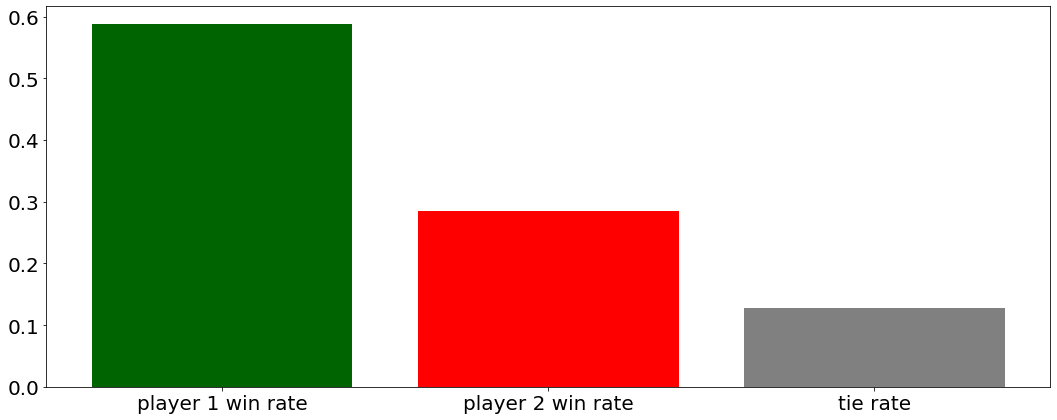

In [8]:
p1_win = sum(results == P1_WIN) / results.shape[0]
p2_win = sum(results == P2_WIN) / results.shape[0]
ties = sum(results == TIE) / results.shape[0]


fig, ax = plt.subplots(figsize=(18, 7))

ax.bar(['player 1 win rate', 'player 2 win rate', 'tie rate'], [p1_win, p2_win, ties], color=['darkgreen', 'red', 'gray'])

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)



and the normalized cumulative reward

Text(0.5, 0, 'episode')

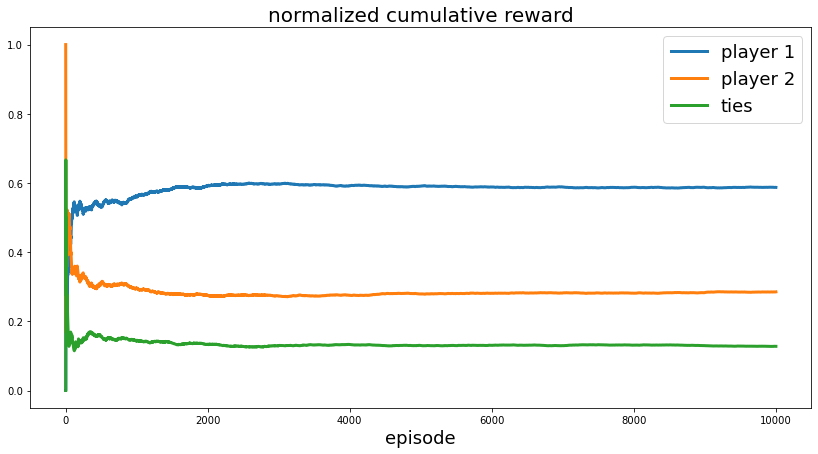

In [9]:
p1_win = np.cumsum(results == P1_WIN) / np.arange(1, results.shape[0]+1)
p2_win = np.cumsum(results == P2_WIN) / np.arange(1, results.shape[0]+1)
ties = np.cumsum(results == TIE) / np.arange(1, results.shape[0]+1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title("normalized cumulative reward", fontsize=20)
ax.plot(range(p1_win.shape[0]), p1_win, '-', label = 'player 1', lw=3)
ax.plot(range(p2_win.shape[0]), p2_win, '-', label = 'player 2', lw=3)
ax.plot(range(ties.shape[0]), ties, '-', label='ties', lw=3)
ax.legend(fontsize=18)
ax.set_xlabel("episode", fontsize=18)


**What can you observe?**

## Q-Agent

Now, we implement an agent that use Q-Learning to choose actions

In [23]:
class QAgent(Agent):
  def __init__(self, side : int, 
               seed : int, gamma = 0.9, 
               alpha = lambda t : 0.5/t, eps = lambda t : 0.1, 
               init_value = 0.6,
               training = True):
    super().__init__("QAgent", side, seed)
    self.Q_table = {} # Q-table
    self.trace = [] # history
    self.eps = eps # epsilon-greedy function
    self.alpha = alpha # stepsize function
    self.gamma = gamma # discount factor
    self.init_value = init_value # initial value
    self.t = 1
    self.n_episodes = 1
    self.training = training

  def _random_action(self, spots):
      # TODO: select a random action among the available (spots). Return the selected action and the index selected
      random_state = np.random.RandomState()#----------------------------
      idx = random_state.choice(len(spots))#----------------------------
      return spots[idx], idx

  def _q_action(self, state_repr, spots):
    # TODO: select the action which maximize the Q table. Return the selected action and the index selected
    idx = np.argmax(self.Q_table[state_repr])#-------------------------------
    return spots[idx], idx


  def select_action(self, board):
    # Get board representation
    state_repr = hash(board)

    # TODO: get empty spots
    spots = board.get_empty_spots()#-----------------------------------

    # TODO: if the state is not in the Q-table add an element to the q-table (map) 
    # with key = state_repr and value = an array initialized with init_value 
    if state_repr not in self.Q_table:
      self.Q_table[state_repr] = self.init_value#-----------------------------

    # TODO: choose an action in epsilon-greedy i.e. 
    # generate random number in (0,1) and
    rand_number = np.random.uniform(0,1)#------------------------------
    # if it is smaller than eps(num_episode) then play a random action
    if rand_number < self.eps(self.n_episodes):#---------------------------------
        selected_action = self._random_action(spots)#-----------------------------
    # otherwise play action which maximize Q
    else:#---------------------------
        selected_action = self._q_action(state_repr, spots)#-----------------------------
    
    selected, idx = selected_action#---------------------------

    self.trace.append((state_repr, idx))
    board.play_action(selected[0], selected[1], self.side)
    return board.check_win(self.side)

  def update(self, board, reward):
    if self.training:
      state_repr = hash(board)
      # TODO: reverse the trace
      reversed = self.trace.reverse()#--------------------------
      alpha = self.alpha(self.n_episodes)
      temp_max = reward
      # TODO: fill the q-table entry with a vector with 9 entries (with value = reward)
      self.Q_table[state_repr] = np.full((9,), reward)#-----------------------------
      if reversed:
        for s, a in reversed:
        # TODO: update Q_table[s][a] using the Q-learning update rule (where temp_max is the maximum of Q in the next action)
            self.Q_table[s][a] = self.Q_table[s][a] + self.alpha * (temp_max - self.Q_table[s][a])#-----------------
            temp_max = self.Q_table[s].max() # update temp_max

      self.n_episodes += 1

  def reset(self):
    self.trace = []


Now train a Q-Agent against a random agent (Q-Agent plays first) and comment the result obtained.

In [32]:
# TODO: insert your code here
p1 = QAgent(CIRCLE, seed=12)
p2 = RandomAgent(CROSS, seed=12)

episodes = 10000
board =Board()

results = run_simulation(p1, p2, board, episodes)

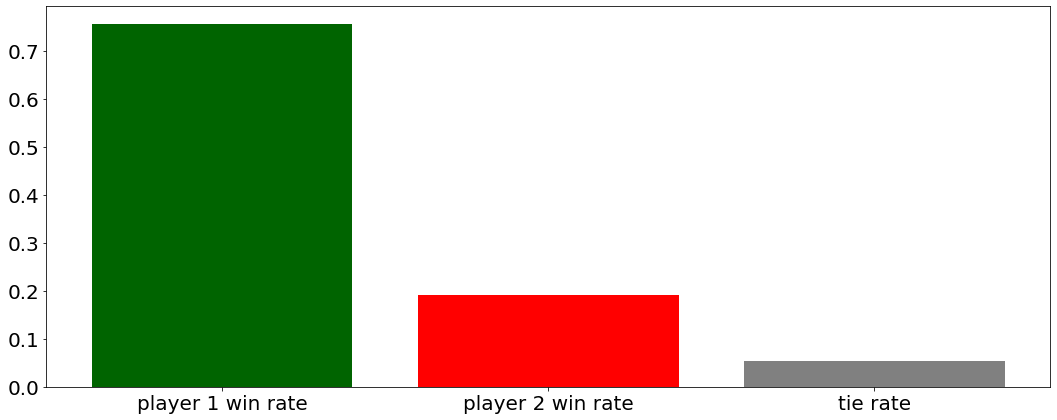

In [33]:
# TODO: plot normalized cumulative reward
p1_win = sum(results == P1_WIN) / results.shape[0]
p2_win = sum(results == P2_WIN) / results.shape[0]
ties = sum(results == TIE) / results.shape[0]


fig, ax = plt.subplots(figsize=(18, 7))

ax.bar(['player 1 win rate', 'player 2 win rate', 'tie rate'], [p1_win, p2_win, ties], color=['darkgreen', 'red', 'gray'])

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


Text(0.5, 0, 'episode')

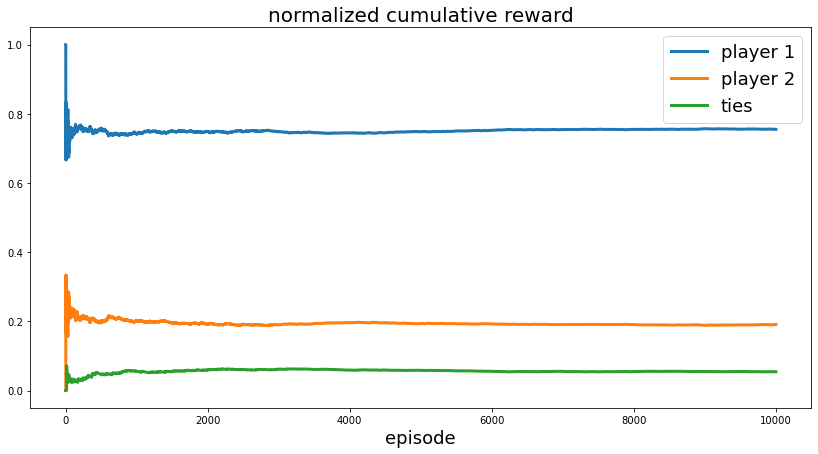

In [34]:
# TODO: plot win rate
p1_win = np.cumsum(results == P1_WIN) / np.arange(1, results.shape[0]+1)
p2_win = np.cumsum(results == P2_WIN) / np.arange(1, results.shape[0]+1)
ties = np.cumsum(results == TIE) / np.arange(1, results.shape[0]+1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title("normalized cumulative reward", fontsize=20)
ax.plot(range(p1_win.shape[0]), p1_win, '-', label = 'player 1', lw=3)
ax.plot(range(p2_win.shape[0]), p2_win, '-', label = 'player 2', lw=3)
ax.plot(range(ties.shape[0]), ties, '-', label='ties', lw=3)
ax.legend(fontsize=18)
ax.set_xlabel("episode", fontsize=18)


Repeat the experiment where the player 1 is the Random agent and the player 2 is the QAgent.

In [29]:
# TODO: Insert your code here
p1 = RandomAgent(CIRCLE, seed=12)
p2 = QAgent(CROSS, seed=12)

episodes = 10000
board =Board()

results = run_simulation(p1, p2, board, episodes)

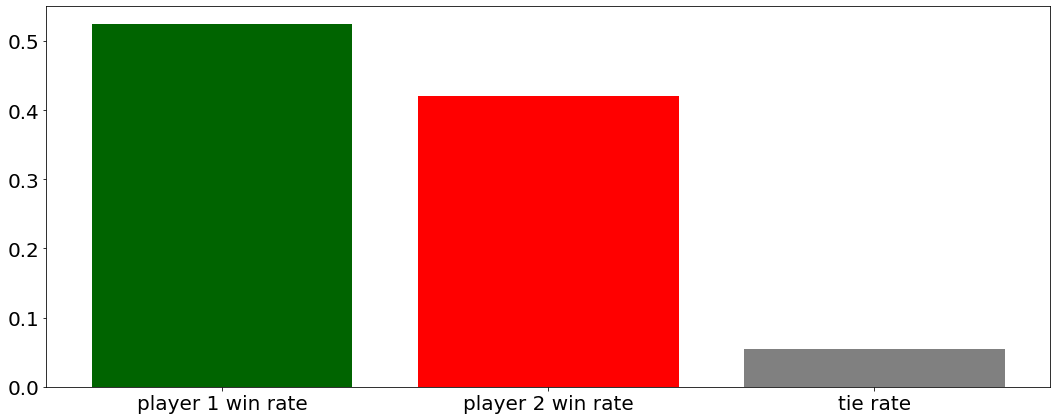

In [30]:
# TODO: plot normalized cumulative reward
p1_win = sum(results == P1_WIN) / results.shape[0]
p2_win = sum(results == P2_WIN) / results.shape[0]
ties = sum(results == TIE) / results.shape[0]


fig, ax = plt.subplots(figsize=(18, 7))

ax.bar(['player 1 win rate', 'player 2 win rate', 'tie rate'], [p1_win, p2_win, ties], color=['darkgreen', 'red', 'gray'])

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


Text(0.5, 0, 'episode')

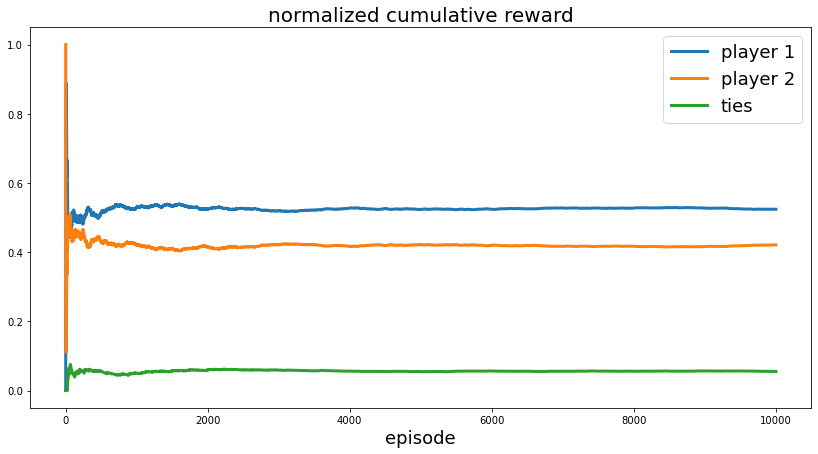

In [31]:
# TODO: plot win rate
p1_win = np.cumsum(results == P1_WIN) / np.arange(1, results.shape[0]+1)
p2_win = np.cumsum(results == P2_WIN) / np.arange(1, results.shape[0]+1)
ties = np.cumsum(results == TIE) / np.arange(1, results.shape[0]+1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title("normalized cumulative reward", fontsize=20)
ax.plot(range(p1_win.shape[0]), p1_win, '-', label = 'player 1', lw=3)
ax.plot(range(p2_win.shape[0]), p2_win, '-', label = 'player 2', lw=3)
ax.plot(range(ties.shape[0]), ties, '-', label='ties', lw=3)
ax.legend(fontsize=18)
ax.set_xlabel("episode", fontsize=18)

Repeat the experiment where both players are QAgents

In [35]:
# TODO: Insert your code here
p1 = QAgent(CIRCLE, seed=12)
p2 = QAgent(CROSS, seed=12)

episodes = 10000
board =Board()

results = run_simulation(p1, p2, board, episodes)

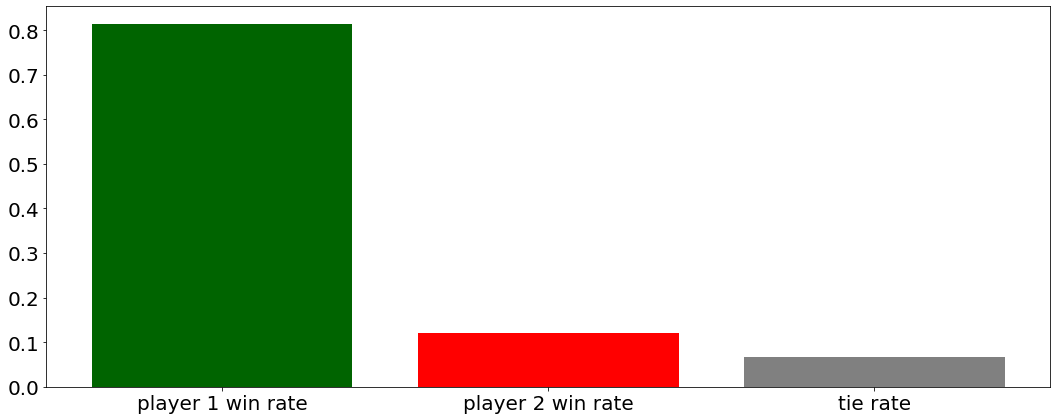

In [36]:
# TODO: plot normalized cumulative reward
p1_win = sum(results == P1_WIN) / results.shape[0]
p2_win = sum(results == P2_WIN) / results.shape[0]
ties = sum(results == TIE) / results.shape[0]


fig, ax = plt.subplots(figsize=(18, 7))

ax.bar(['player 1 win rate', 'player 2 win rate', 'tie rate'], [p1_win, p2_win, ties], color=['darkgreen', 'red', 'gray'])

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

Text(0.5, 0, 'episode')

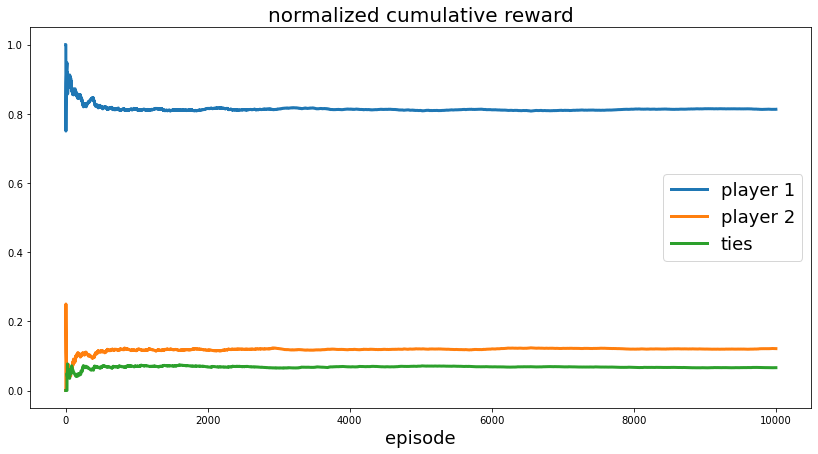

In [37]:
# TODO: plot win rate
p1_win = np.cumsum(results == P1_WIN) / np.arange(1, results.shape[0]+1)
p2_win = np.cumsum(results == P2_WIN) / np.arange(1, results.shape[0]+1)
ties = np.cumsum(results == TIE) / np.arange(1, results.shape[0]+1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title("normalized cumulative reward", fontsize=20)
ax.plot(range(p1_win.shape[0]), p1_win, '-', label = 'player 1', lw=3)
ax.plot(range(p2_win.shape[0]), p2_win, '-', label = 'player 2', lw=3)
ax.plot(range(ties.shape[0]), ties, '-', label='ties', lw=3)
ax.legend(fontsize=18)
ax.set_xlabel("episode", fontsize=18)

**Describe the results obtained here**:
the player how playes first has more chance of winning.
when both players are random agents the first player wins most of the time.
when first plare is Qagent and the second one is a random one, the Qagent wins more than 75 percent of the time and when the we replace they turns the Qagent wins something like 42 percent of the times which represent the importance of playing first.
And finally when two Qagents play against each other the first player wins more than 80 percent of the games.

Now repeat the previous experiments changing:
- the discount factor
- the epsilon parameter

**Describe your finding:**
We have changed discount factor and the result were mostly the same but the beginning was different; but when we increased the epsilon the second player won a bit more.

In [6]:
# TODO: Insert your code here
class QAgent_Changed(Agent):
  def __init__(self, side : int, 
               seed : int, gamma = 0.5, 
               alpha = lambda t : 0.5/t, eps = lambda t : 0.1, 
               init_value = 0.6,
               training = True):
    super().__init__("QAgent", side, seed)
    self.Q_table = {} # Q-table
    self.trace = [] # history
    self.eps = eps # epsilon-greedy function
    self.alpha = alpha # stepsize function
    self.gamma = gamma # discount factor
    self.init_value = init_value # initial value
    self.t = 1
    self.n_episodes = 1
    self.training = training

  def _random_action(self, spots):
      # TODO: select a random action among the available (spots). Return the selected action and the index selected
      random_state = np.random.RandomState()#----------------------------
      idx = random_state.choice(len(spots))#----------------------------
      return spots[idx], idx

  def _q_action(self, state_repr, spots):
    # TODO: select the action which maximize the Q table. Return the selected action and the index selected
    idx = np.argmax(self.Q_table[state_repr])#-------------------------------
    return spots[idx], idx


  def select_action(self, board):
    # Get board representation
    state_repr = hash(board)

    # TODO: get empty spots
    spots = board.get_empty_spots()#-----------------------------------

    # TODO: if the state is not in the Q-table add an element to the q-table (map) 
    # with key = state_repr and value = an array initialized with init_value 
    if state_repr not in self.Q_table:
      self.Q_table[state_repr] = self.init_value#-----------------------------

    # TODO: choose an action in epsilon-greedy i.e. 
    # generate random number in (0,1) and
    rand_number = np.random.uniform(0,1)#------------------------------
    # if it is smaller than eps(num_episode) then play a random action
    if rand_number < self.eps(self.n_episodes):#---------------------------------
        selected_action = self._random_action(spots)#-----------------------------
    # otherwise play action which maximize Q
    else:#---------------------------
        selected_action = self._q_action(state_repr, spots)#-----------------------------
    
    selected, idx = selected_action#---------------------------

    self.trace.append((state_repr, idx))
    board.play_action(selected[0], selected[1], self.side)
    return board.check_win(self.side)

  def update(self, board, reward):
    if self.training:
      state_repr = hash(board)
      # TODO: reverse the trace
      reversed = self.trace.reverse()#--------------------------
      alpha = self.alpha(self.n_episodes)
      temp_max = reward
      # TODO: fill the q-table entry with a vector with 9 entries (with value = reward)
      self.Q_table[state_repr] = np.full((9,), reward)#-----------------------------
      if reversed:
        for s, a in reversed:
        # TODO: update Q_table[s][a] using the Q-learning update rule (where temp_max is the maximum of Q in the next action)
            self.Q_table[s][a] = self.Q_table[s][a] + self.alpha * (temp_max - self.Q_table[s][a])#-----------------
            temp_max = self.Q_table[s].max() # update temp_max

      self.n_episodes += 1

  def reset(self):
    self.trace = []


Text(0.5, 0, 'episode')

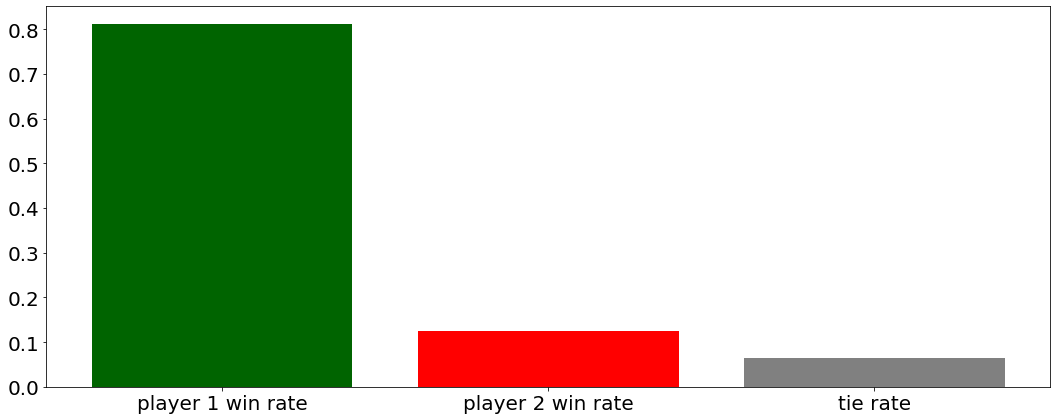

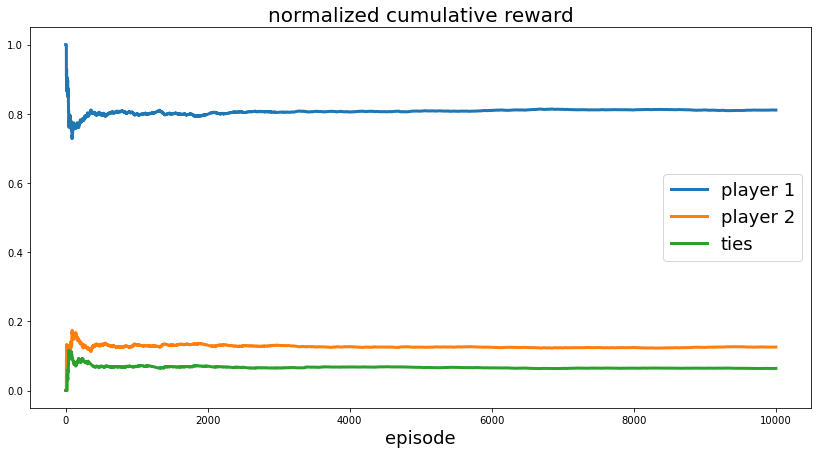

In [7]:
p1 = QAgent_Changed(CIRCLE, seed=12)
p2 = QAgent(CROSS, seed=12)

episodes = 10000
board =Board()

results = run_simulation(p1, p2, board, episodes)

p1_win = sum(results == P1_WIN) / results.shape[0]
p2_win = sum(results == P2_WIN) / results.shape[0]
ties = sum(results == TIE) / results.shape[0]


fig, ax = plt.subplots(figsize=(18, 7))

ax.bar(['player 1 win rate', 'player 2 win rate', 'tie rate'], [p1_win, p2_win, ties], color=['darkgreen', 'red', 'gray'])

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

p1_win = np.cumsum(results == P1_WIN) / np.arange(1, results.shape[0]+1)
p2_win = np.cumsum(results == P2_WIN) / np.arange(1, results.shape[0]+1)
ties = np.cumsum(results == TIE) / np.arange(1, results.shape[0]+1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title("normalized cumulative reward", fontsize=20)
ax.plot(range(p1_win.shape[0]), p1_win, '-', label = 'player 1', lw=3)
ax.plot(range(p2_win.shape[0]), p2_win, '-', label = 'player 2', lw=3)
ax.plot(range(ties.shape[0]), ties, '-', label='ties', lw=3)
ax.legend(fontsize=18)
ax.set_xlabel("episode", fontsize=18)

Text(0.5, 0, 'episode')

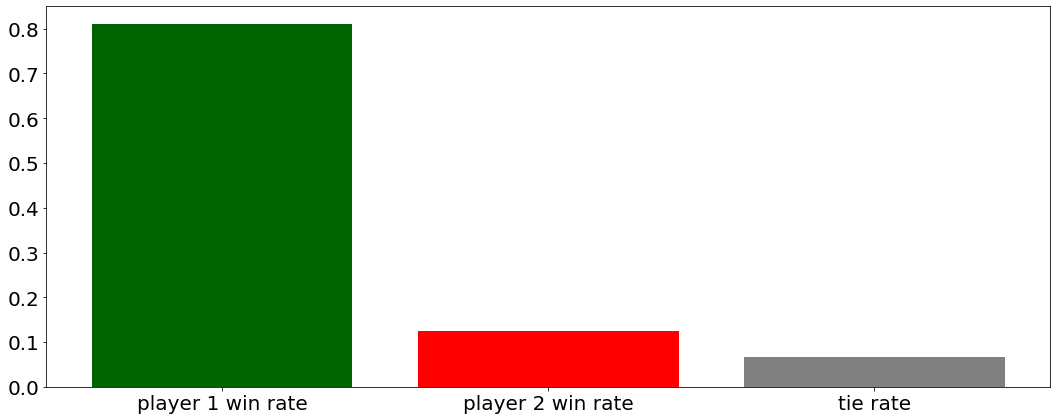

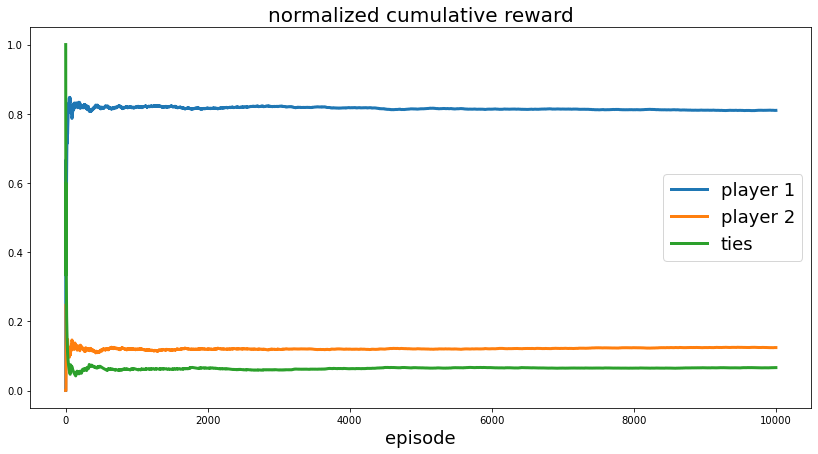

In [8]:
p1 = QAgent(CIRCLE, seed=12)
p2 = QAgent_Changed(CROSS, seed=12)

episodes = 10000
board =Board()

results = run_simulation(p1, p2, board, episodes)

p1_win = sum(results == P1_WIN) / results.shape[0]
p2_win = sum(results == P2_WIN) / results.shape[0]
ties = sum(results == TIE) / results.shape[0]


fig, ax = plt.subplots(figsize=(18, 7))

ax.bar(['player 1 win rate', 'player 2 win rate', 'tie rate'], [p1_win, p2_win, ties], color=['darkgreen', 'red', 'gray'])

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

p1_win = np.cumsum(results == P1_WIN) / np.arange(1, results.shape[0]+1)
p2_win = np.cumsum(results == P2_WIN) / np.arange(1, results.shape[0]+1)
ties = np.cumsum(results == TIE) / np.arange(1, results.shape[0]+1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title("normalized cumulative reward", fontsize=20)
ax.plot(range(p1_win.shape[0]), p1_win, '-', label = 'player 1', lw=3)
ax.plot(range(p2_win.shape[0]), p2_win, '-', label = 'player 2', lw=3)
ax.plot(range(ties.shape[0]), ties, '-', label='ties', lw=3)
ax.legend(fontsize=18)
ax.set_xlabel("episode", fontsize=18)

In [9]:
# TODO: Insert your code here
class QAgent_Changed_2(Agent):
  def __init__(self, side : int, 
               seed : int, gamma = 0.9, 
               alpha = lambda t : 0.5/t, eps = lambda t : 0.3, 
               init_value = 0.6,
               training = True):
    super().__init__("QAgent", side, seed)
    self.Q_table = {} # Q-table
    self.trace = [] # history
    self.eps = eps # epsilon-greedy function
    self.alpha = alpha # stepsize function
    self.gamma = gamma # discount factor
    self.init_value = init_value # initial value
    self.t = 1
    self.n_episodes = 1
    self.training = training

  def _random_action(self, spots):
      # TODO: select a random action among the available (spots). Return the selected action and the index selected
      random_state = np.random.RandomState()#----------------------------
      idx = random_state.choice(len(spots))#----------------------------
      return spots[idx], idx

  def _q_action(self, state_repr, spots):
    # TODO: select the action which maximize the Q table. Return the selected action and the index selected
    idx = np.argmax(self.Q_table[state_repr])#-------------------------------
    return spots[idx], idx


  def select_action(self, board):
    # Get board representation
    state_repr = hash(board)

    # TODO: get empty spots
    spots = board.get_empty_spots()#-----------------------------------

    # TODO: if the state is not in the Q-table add an element to the q-table (map) 
    # with key = state_repr and value = an array initialized with init_value 
    if state_repr not in self.Q_table:
      self.Q_table[state_repr] = self.init_value#-----------------------------

    # TODO: choose an action in epsilon-greedy i.e. 
    # generate random number in (0,1) and
    rand_number = np.random.uniform(0,1)#------------------------------
    # if it is smaller than eps(num_episode) then play a random action
    if rand_number < self.eps(self.n_episodes):#---------------------------------
        selected_action = self._random_action(spots)#-----------------------------
    # otherwise play action which maximize Q
    else:#---------------------------
        selected_action = self._q_action(state_repr, spots)#-----------------------------
    
    selected, idx = selected_action#---------------------------

    self.trace.append((state_repr, idx))
    board.play_action(selected[0], selected[1], self.side)
    return board.check_win(self.side)

  def update(self, board, reward):
    if self.training:
      state_repr = hash(board)
      # TODO: reverse the trace
      reversed = self.trace.reverse()#--------------------------
      alpha = self.alpha(self.n_episodes)
      temp_max = reward
      # TODO: fill the q-table entry with a vector with 9 entries (with value = reward)
      self.Q_table[state_repr] = np.full((9,), reward)#-----------------------------
      if reversed:
        for s, a in reversed:
        # TODO: update Q_table[s][a] using the Q-learning update rule (where temp_max is the maximum of Q in the next action)
            self.Q_table[s][a] = self.Q_table[s][a] + self.alpha * (temp_max - self.Q_table[s][a])#-----------------
            temp_max = self.Q_table[s].max() # update temp_max

      self.n_episodes += 1

  def reset(self):
    self.trace = []


Text(0.5, 0, 'episode')

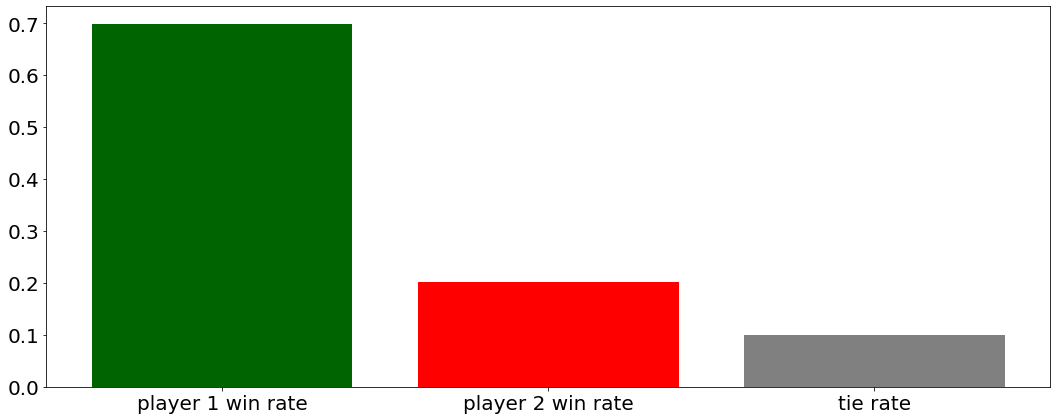

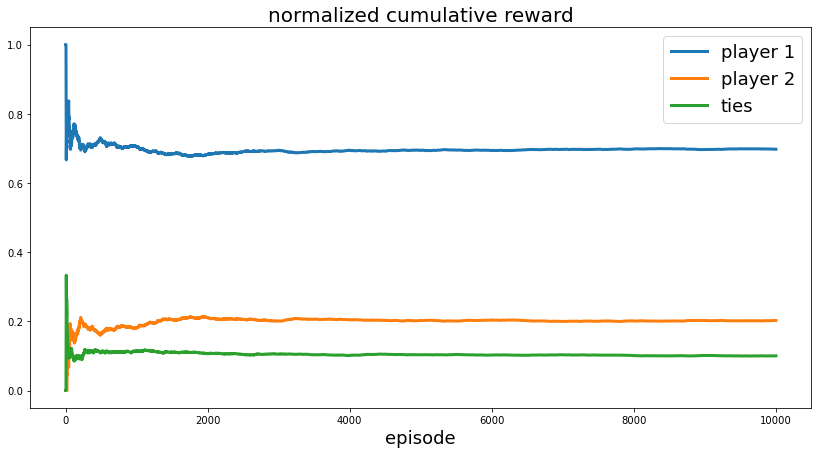

In [10]:
p1 = QAgent_Changed_2(CIRCLE, seed=12)
p2 = QAgent(CROSS, seed=12)

episodes = 10000
board =Board()

results = run_simulation(p1, p2, board, episodes)

p1_win = sum(results == P1_WIN) / results.shape[0]
p2_win = sum(results == P2_WIN) / results.shape[0]
ties = sum(results == TIE) / results.shape[0]


fig, ax = plt.subplots(figsize=(18, 7))

ax.bar(['player 1 win rate', 'player 2 win rate', 'tie rate'], [p1_win, p2_win, ties], color=['darkgreen', 'red', 'gray'])

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

p1_win = np.cumsum(results == P1_WIN) / np.arange(1, results.shape[0]+1)
p2_win = np.cumsum(results == P2_WIN) / np.arange(1, results.shape[0]+1)
ties = np.cumsum(results == TIE) / np.arange(1, results.shape[0]+1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title("normalized cumulative reward", fontsize=20)
ax.plot(range(p1_win.shape[0]), p1_win, '-', label = 'player 1', lw=3)
ax.plot(range(p2_win.shape[0]), p2_win, '-', label = 'player 2', lw=3)
ax.plot(range(ties.shape[0]), ties, '-', label='ties', lw=3)
ax.legend(fontsize=18)
ax.set_xlabel("episode", fontsize=18)

Text(0.5, 0, 'episode')

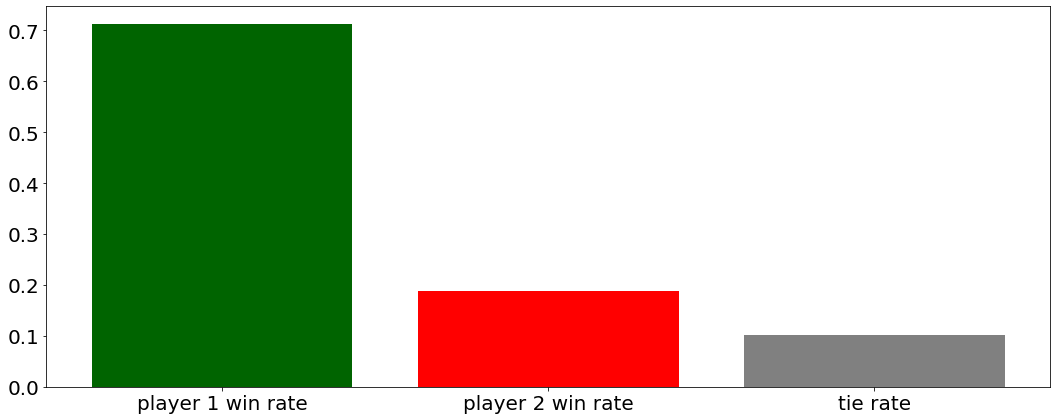

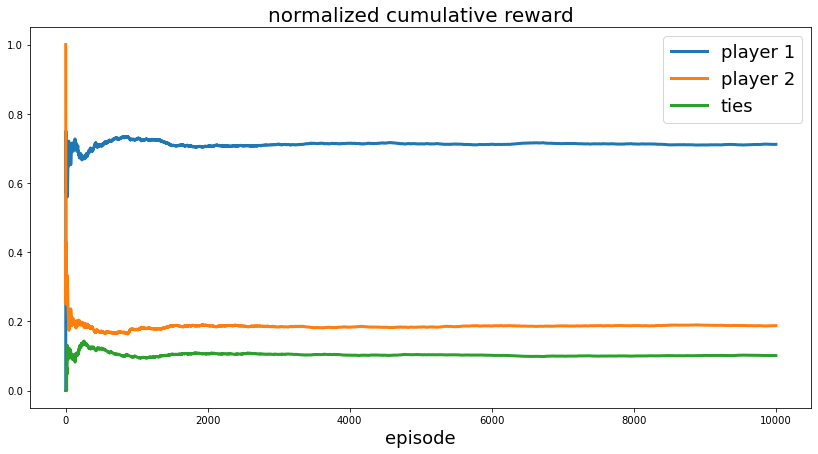

In [11]:
p1 = QAgent(CIRCLE, seed=12)
p2 = QAgent_Changed_2(CROSS, seed=12)

episodes = 10000
board =Board()

results = run_simulation(p1, p2, board, episodes)

p1_win = sum(results == P1_WIN) / results.shape[0]
p2_win = sum(results == P2_WIN) / results.shape[0]
ties = sum(results == TIE) / results.shape[0]


fig, ax = plt.subplots(figsize=(18, 7))

ax.bar(['player 1 win rate', 'player 2 win rate', 'tie rate'], [p1_win, p2_win, ties], color=['darkgreen', 'red', 'gray'])

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

p1_win = np.cumsum(results == P1_WIN) / np.arange(1, results.shape[0]+1)
p2_win = np.cumsum(results == P2_WIN) / np.arange(1, results.shape[0]+1)
ties = np.cumsum(results == TIE) / np.arange(1, results.shape[0]+1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title("normalized cumulative reward", fontsize=20)
ax.plot(range(p1_win.shape[0]), p1_win, '-', label = 'player 1', lw=3)
ax.plot(range(p2_win.shape[0]), p2_win, '-', label = 'player 2', lw=3)
ax.plot(range(ties.shape[0]), ties, '-', label='ties', lw=3)
ax.legend(fontsize=18)
ax.set_xlabel("episode", fontsize=18)